# Image Classification - Search Space and HPO

:label:`sec_imgadvanced`


While the :ref:`sec_imgquick` introduced basic usage of AutoGluon `fit`, `evaluate`, `predict` with default configurations, this tutorial dives into the various options that you can specify for more advanced control over the fitting process.

These options include: 
- Defining the search space of various hyperparameter values for the training of neural networks
- Specifying how to search through your choosen hyperparameter space
- Specifying how to schedule jobs to train a network under a particular hyperparameter configuration.

The advanced functionalities of AutoGluon enable you to use your external knowledge about your particular prediction problem and computing resources to guide the training process. If properly used, you may be able to achieve superior performance within less training time.

**Tip**: If you are new to AutoGluon, review :ref:`sec_imgquick` to learn the basics of the AutoGluon API.

We begin by letting AutoGluon know that [`ImageClassification`](/api/autogluon.task.html#autogluon.task.ImageClassification) is the task of interest:

In [1]:
import autogluon as ag
from autogluon import ImageClassification as task

## Create AutoGluon Dataset

Let's first create the dataset using the same subset of the `Shopee-IET` dataset as the :ref:`sec_imgquick` tutorial.
Recall that because we only specify the `train_path`, a 90/10 train/validation split is automatically performed.

In [2]:
filename = ag.download('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
ag.unzip(filename)

'data'

In [3]:
dataset = task.Dataset('data/train')

## Specify which Networks to Try

We start with specifying the pretrained neural network candidates.
Given such a list, AutoGluon tries to train different networks from this list to identify the best-performing candidate.
This is an example of a :class:`autogluon.space.Categorical` search space, in which there are a limited number of values to choose from.

In [4]:
import gluoncv as gcv

@ag.func(
    multiplier=ag.Categorical(0.25, 0.5),
)
def get_mobilenet(multiplier):
    return gcv.model_zoo.MobileNetV2(multiplier=multiplier, classes=4)

net = ag.space.Categorical('mobilenet0.25', get_mobilenet())
print(net)

Categorical['mobilenet0.25', AutoGluonObject]


## Specify the Optimizer and Its Search Space

Similarly, we can manually specify the optimizer candidates.
We can construct another search space to identify which optimizer works best for our task, and also identify the best hyperparameter configurations for this optimizer.
Additionally, we can customize the optimizer-specific hyperparameters search spaces, such as learning rate and weight decay using :class:`autogluon.space.Real`.

In [5]:
from mxnet import optimizer as optim

@ag.obj(
    learning_rate=ag.space.Real(1e-4, 1e-2, log=True),
    momentum=ag.space.Real(0.85, 0.95),
    wd=ag.space.Real(1e-6, 1e-2, log=True)
)
class NAG(optim.NAG):
    pass

optimizer = NAG()
print(optimizer)

AutoGluonObject -- NAG


## Search Algorithms

In AutoGluon, :meth:`autogluon.searcher` supports different search search_strategys for both hyperparameter optimization and architecture search.
Beyond simply specifying the space of hyperparameter configurations to search over, you can also tell AutoGluon what strategy it should employ to actually search through this space. 
This process of finding good hyperparameters from a given search space is commonly referred to as *hyperparameter optimization* (HPO) or *hyperparameter tuning*. 
:meth:`autogluon.scheduler` orchestrates how individual training jobs are scheduled.
We currently support random search, Hyperband, and Bayesian Optimization. Although these are simple techniques, they can be surprisingly powerful when parallelized, which can be easily enabled in AutoGluon.

### Bayesian Optimization

Here is an example of using Bayesian Optimization using :class:`autogluon.searcher.SKoptSearcher`.

Bayesian Optimization fits a probabilistic *surrogate model* to estimate the function that relates each hyperparameter configuration to the resulting performance of a model trained under this hyperparameter configuration.

You can specify what kind of surrogate model to use (e.g., Gaussian Process, Random Forest, etc.), in addition to which acquisition function to employ (e.g., Expected Improvement, Lower Confidence Bound, etc.).  In the following, we tell `fit` to perform Bayesian optimization using a Random Forest surrogate model with acquisitions based on Expected Improvement.
For more information, see :class:`autogluon.searcher.SKoptSearcher`.

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.17.200/4297/1' processes=1 threads=8, memory=64.38 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



/home/ec2-user/anaconda3/envs/autogluon/lib/python3.7/site-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring data/train/BabyPants/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
Model file not found. Downloading.


100%|██████████| 1093/1093 [00:00<00:00, 2236.34KB/s]


Finished Task with config: {'net.1.multiplier.choice': 0, 'net.choice': 0, 'optimizer.learning_rate': 0.001, 'optimizer.momentum': 0.9, 'optimizer.wd': 0.0001} and reward: 0.39375


/home/ec2-user/anaconda3/envs/autogluon/lib/python3.7/site-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring data/train/BabyPants/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))


Finished Task with config: {'net.1.multiplier.choice': 1, 'net.choice': 0, 'optimizer.learning_rate': 0.0017422510893267207, 'optimizer.momentum': 0.8987009414070393, 'optimizer.wd': 0.0001198611701580152} and reward: 0.45
/home/ec2-user/anaconda3/envs/autogluon/lib/python3.7/site-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring data/train/BabyPants/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))


Saving Training Curve in checkpoint/plot_training_curves.png


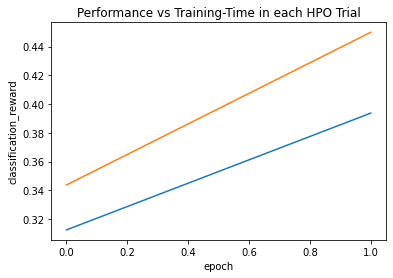

Top-1 val acc: 0.450


/home/ec2-user/anaconda3/envs/autogluon/lib/python3.7/site-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring data/train/BabyPants/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))


In [6]:
time_limits = 2*60
epochs = 2

classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      search_strategy='skopt', 
                      search_options={'base_estimator': 'RF', 'acq_func': 'EI'},
                      time_limits=time_limits,
                      epochs=epochs,
                      ngpus_per_trial=1)

print('Top-1 val acc: %.3f' % classifier.results[classifier.results['reward_attr']])

Load the test dataset and evaluate:

In [7]:
test_dataset = task.Dataset('data/test', train=False)

test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.547


### Hyperband Early Stopping

AutoGluon currently supports scheduling trials in serial order and with early stopping
(e.g., if the performance of the model early within training already looks bad, the trial may be terminated early to free up resources).
Here is an example of using an early stopping scheduler :class:`autogluon.scheduler.HyperbandScheduler`:

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


scheduler: HyperbandScheduler(terminator: HyperbandStopping_Manager(reward_attr: classification_reward, time_attr: epoch, reduction_factor: 4, max_t: 2, brackets: [Bracket: Iter 1.000: None])


Finished Task with config: {'net.1.multiplier.choice': 0, 'net.choice': 0, 'optimizer.learning_rate': 0.001, 'optimizer.momentum': 0.9, 'optimizer.wd': 0.0001} and reward: 0.4


Finished Task with config: {'net.1.multiplier.choice': 0, 'net.choice': 0, 'optimizer.learning_rate': 0.0001546545171937746, 'optimizer.momentum': 0.8541599612024005, 'optimizer.wd': 1.4799414760115509e-06} and reward: 0.1875


Saving Training Curve in checkpoint/plot_training_curves.png


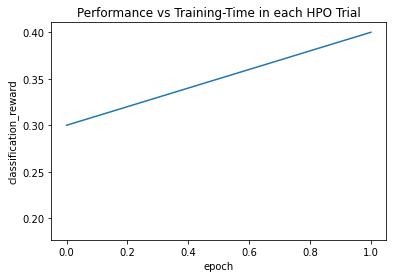

Top-1 val acc: 0.400


In [8]:
search_strategy = 'hyperband'

classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      search_strategy=search_strategy,
                      epochs=epochs,
                      num_trials=2,
                      verbose=False,
                      plot_results=True,
                      ngpus_per_trial=1,
                      grace_period=1)

print('Top-1 val acc: %.3f' % classifier.results[classifier.results['reward_attr']])

The test top-1 accuracy are:

In [9]:
test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.422


For a comparison of different search algorithms and scheduling strategies, see :ref:`course_alg`.
For more options using `fit`, see :class:`autogluon.task.ImageClassification`.